<a href="https://colab.research.google.com/github/DiegoAll/ml-projects/blob/main/Diego_Regresi%C3%B3n_con_RF_y_GB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller 1: Regresión con Random Forest y Gradient Boosting


In [ ]:
from google.colab import drive 

drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/Colab Notebooks' 


/content/drive/MyDrive/Colab Notebooks


En este taller se aplicará ensambes de árboles de decisión tipo random forest y gradient boosting a un conjunto de datos de jugadores del video juego FIFA 19. Los datos utilizados son un subconjunto modificado de [este set de datos](https://www.kaggle.com/karangadiya/fifa19) y se encuentran en el archivo `FIFA 19 players.csv`. La tarea a realizar consiste en predecir el salario (wage) de los jugadores.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from matplotlib import pyplot as plt

from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder, # Para el error de abajo se utiliza mejor este de Ordinal ... solo tengo 2 categoricas
    #BinaryEncoder,
    StandardScaler,
    PolynomialFeatures,
    FunctionTransformer,
)

In [ ]:
#Obtenemos los datos
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE' -O players.csv

--2023-05-17 06:23:18--  https://docs.google.com/uc?export=download&id=1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE
Resolving docs.google.com (docs.google.com)... 142.251.171.139, 142.251.171.102, 142.251.171.138, ...
Connecting to docs.google.com (docs.google.com)|142.251.171.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mfiortsbb04cuf7dlv6g806o9pq2ahkh/1684304550000/15315348669826032119/*/1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE?e=download&uuid=a4cbbad8-0414-4162-84d3-3fcc454cd1bd [following]
--2023-05-17 06:23:19--  https://doc-0s-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mfiortsbb04cuf7dlv6g806o9pq2ahkh/1684304550000/15315348669826032119/*/1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE?e=download&uuid=a4cbbad8-0414-4162-84d3-3fcc454cd1bd
Resolving doc-0s-6c-docs.googleusercontent.com (doc-0s-6c-docs.googleusercontent.com)... 142.250.148.132, 2607:

In [ ]:
# Definamos el "random_state" para que los resultados sean reproducibles:
random_state=42

In [ ]:
# Cambiemos la fuente de las gráficas de matplotlib:
plt.rc('font', family='serif', size=12)

## Preprocesamiento de datos

In [ ]:
# Carguemos los datos:
data = pd.read_csv('players.csv')
data

,Name,Age,Overall,Wage,Preferred Foot,International Reputation,Weak Foot,Skill Moves,LS,ST,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,L. Messi,31,94,565000,Left,5.0,4.0,4.0,90.0,90.0,...,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0
1,Cristiano Ronaldo,33,94,405000,Right,5.0,4.0,5.0,94.0,94.0,...,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0
2,Neymar Jr,26,92,290000,Right,5.0,5.0,5.0,87.0,87.0,...,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0
3,K. De Bruyne,27,91,355000,Right,4.0,5.0,4.0,85.0,85.0,...,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0
4,E. Hazard,27,91,340000,Right,4.0,4.0,4.0,86.0,86.0,...,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15921,J. Lundstram,19,47,1000,Right,1.0,2.0,2.0,44.0,44.0,...,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,47.0
15922,N. Christoffersson,19,47,1000,Right,1.0,2.0,2.0,47.0,47.0,...,42.0,47.0,16.0,46.0,33.0,43.0,42.0,22.0,15.0,19.0
15923,B. Worman,16,47,1000,Right,1.0,3.0,2.0,47.0,47.0,...,45.0,32.0,15.0,48.0,43.0,55.0,41.0,32.0,13.0,11.0
15924,D. Walker-Rice,17,47,1000,Right,1.0,3.0,2.0,49.0,49.0,...,34.0,33.0,22.0,44.0,47.0,50.0,46.0,20.0,25.0,27.0


Se realiza la imputación de datos (Nan)

In [ ]:
data.dropna(axis = 0, inplace = True)

In [ ]:
# Veamos la descripción del dataset:
### CÓDIGO AQUÍ ###

# Tamaño de la tabla
data.shape

# Descripción del dataset
# iterating the columns
# for col in data.columns:
#    print(col)

# Otra descripción en forma de lista
# print("######## Array ######")
# list(data.columns)

(15926, 63)

In [ ]:
#Muestra el tipo de dato de cada columna
data.dtypes

Name               object
Age                 int64
Overall             int64
Wage                int64
Preferred Foot     object
                   ...   
Penalties         float64
Composure         float64
Marking           float64
StandingTackle    float64
SlidingTackle     float64
Length: 63, dtype: object

In [ ]:
# Veamos la descripción del dataset:
data.describe(include='all')

,Name,Age,Overall,Wage,Preferred Foot,International Reputation,Weak Foot,Skill Moves,LS,ST,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
count,15926,15926.000000,15926.000000,15926.000000,15926,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,...,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.00000,15926.000000,15926.000000,15926.000000
unique,15114,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,J. Rodríguez,NaN,NaN,NaN,Right,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,9,NaN,NaN,NaN,11969,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,24.991209,66.446189,10254.866256,NaN,1.116037,3.004081,2.533342,59.842647,59.842647,...,51.446126,59.575411,50.401168,54.844405,55.494726,52.118234,60.34654,51.273703,51.883021,49.593118
std,NaN,4.552866,6.809244,22692.769542,NaN,0.397762,0.636845,0.618186,9.141407,9.141407,...,15.718376,14.432944,18.797738,14.665434,12.897478,12.501841,10.14202,17.198926,19.161875,19.162508
min,NaN,16.000000,46.000000,1000.000000,NaN,1.000000,1.000000,2.000000,33.000000,33.000000,...,11.000000,13.000000,10.000000,11.000000,12.000000,12.000000,29.00000,10.000000,10.000000,10.000000
25%,NaN,21.000000,62.000000,1000.000000,NaN,1.000000,3.000000,2.000000,54.000000,54.000000,...,40.000000,50.000000,34.000000,46.000000,47.000000,42.000000,53.00000,37.000000,35.000000,32.000000
50%,NaN,25.000000,66.000000,3000.000000,NaN,1.000000,3.000000,2.000000,60.000000,60.000000,...,54.000000,61.000000,56.000000,57.000000,57.000000,52.000000,61.00000,56.000000,59.000000,56.000000
75%,NaN,28.000000,71.000000,10000.000000,NaN,1.000000,3.000000,3.000000,66.000000,66.000000,...,64.000000,70.000000,65.000000,65.000000,65.000000,61.000000,68.00000,65.000000,67.000000,65.000000


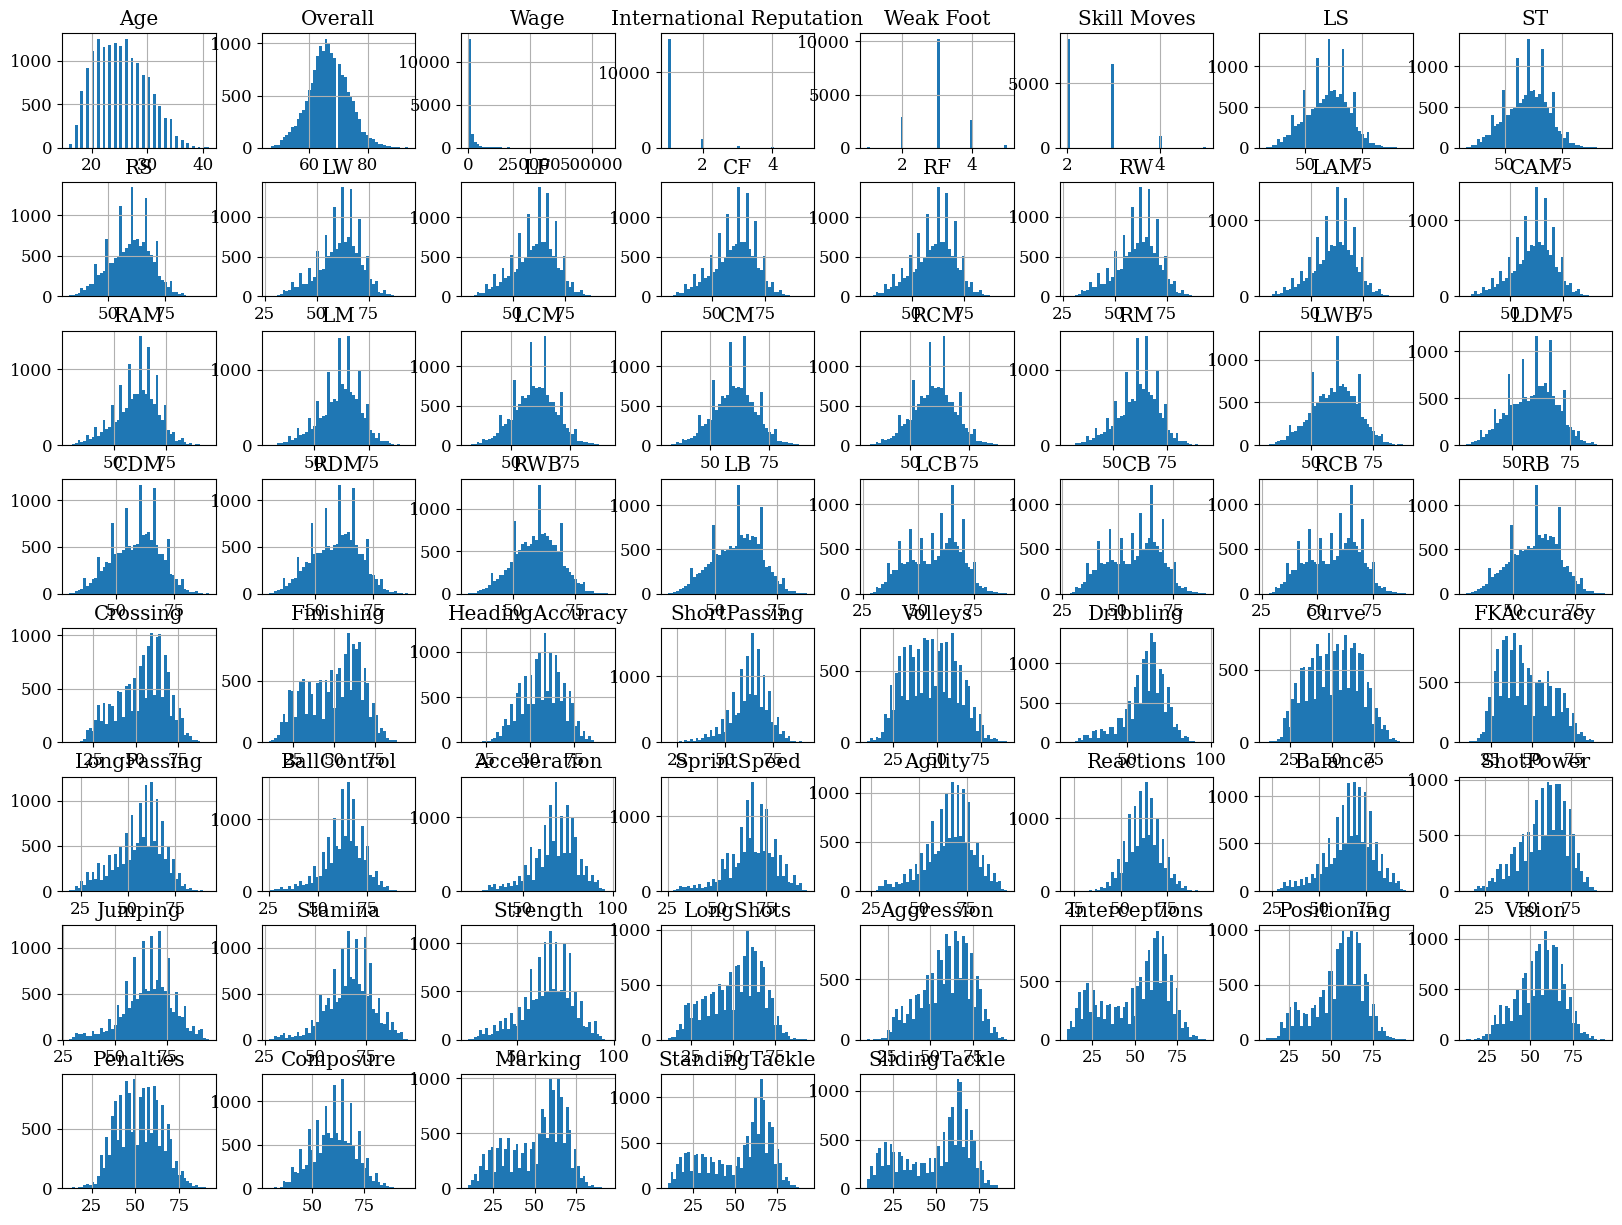

In [ ]:
#Veamos la distribución de las columnas
# No hace nada con la columna nombre
data.hist(bins=50, figsize=(20, 15));

In [ ]:
# Obtengamos la distribución de valores de la variable `Preferred Foot`:
# tip: pandas function value_counts()
# En el ejercicio anterior contaba los valores unicos de la columna fuelType (variable categorica)
data['Preferred Foot'].value_counts()


Right    11969
Left      3957
Name: Preferred Foot, dtype: int64

In [ ]:
# Dado que esta columna es categorica, debemos incluir en el Pipeline su transformación. Utilizaremos 
# codificación binaria
#tip: scikit-learn BinaryEncoder -> Igual funcionamiento a OrdinalEncoder
# ACLARAR TEMA ERROR AL IMPORTAR LA LIBRERIA, RECORDAR ERROR Y CONSULTA A PROFESOR. PORQUE SOLO SE TIENEN 2 VARIABLES CATEGORICAS HABIA MENCIONADO EN CLASE, SE PUEDE UTILIZAR ORDINAL ENCODING.




**La porción de código a continuación la realiza el profesor en una asesoria. "categorical_transformer"**

In [ ]:
# Apliquemos "ordinal encoding" a las características categóricas
# (dado que usaremos modelos basados en árboles de decisión):

#Encontrar variables numéricas y categóricas
cat_cols = data.select_dtypes(include=object).columns
num_cols = data.select_dtypes(include=np.number).columns

categorical_transformer = Pipeline(
    steps=[("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))]
)
numerical_trasnformer = 'passthrough'

In [ ]:
cat_cols

Index(['Name', 'Preferred Foot'], dtype='object')

In [ ]:
num_cols

Index(['Age', 'Overall', 'Wage', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM',
       'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
       'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle'],
      dtype='object')

In [ ]:
categorical_transformer

Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1))])

In [ ]:
encoder = categorical_transformer.fit(data.loc[:,cat_cols])
encoder["encoder"].categories_

[array(['A. Abang', 'A. Abdellaoui', 'A. Abdennour', ..., 'Óscar Pinchi',
        'Óscar Plano', 'Óscar Valentín'], dtype=object),
 array(['Left', 'Right'], dtype=object)]

## Regresión

**Nota:** Dejaremos la coulmna `Name` en el datafrme para poder identificar a los jugadores, pero **la debemos excluir** al definir las variables `X_train`, `y_train`, `X_val`, `y_val`, `X_test`, and `y_test`.

Nota: En los ejercicios anteriores se realizaba la separación en datos de entrenamiento, prueba y validación. Para esta técnica de Gradient Boosting , por el tema de la crossvalidación la libreria hace las separaciones en entrenamiento y test (hace sintonizacion de hiperparametros) e internamente a partir de los datos de entrenamiento obtiene los de validación calculandolos varias veces.

In [ ]:
# Separemos los datos en conjuntos de entrenamiento (80 %) y prueba (20 %):

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns= ['Name','Wage']),
    data['Wage'], test_size=0.2,
    random_state=random_state
)

In [ ]:
# Visualizar los datos de Entrenamiento

X_train

,Age,Overall,Preferred Foot,International Reputation,Weak Foot,Skill Moves,LS,ST,RS,LW,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
13555,18,60,Right,1.0,3.0,2.0,60.0,60.0,60.0,55.0,...,42.0,66.0,19.0,63.0,45.0,48.0,47.0,17.0,22.0,20.0
1665,24,75,Right,1.0,3.0,3.0,64.0,64.0,64.0,67.0,...,59.0,88.0,78.0,54.0,68.0,76.0,69.0,72.0,73.0,73.0
14878,20,56,Right,1.0,3.0,3.0,52.0,52.0,52.0,57.0,...,42.0,27.0,16.0,43.0,52.0,56.0,44.0,25.0,30.0,28.0
7471,25,67,Left,1.0,2.0,3.0,66.0,66.0,66.0,67.0,...,57.0,75.0,18.0,60.0,65.0,56.0,70.0,34.0,18.0,15.0
2582,29,73,Right,1.0,3.0,3.0,74.0,74.0,74.0,70.0,...,71.0,71.0,17.0,72.0,67.0,64.0,66.0,14.0,32.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13418,20,60,Right,1.0,4.0,3.0,58.0,58.0,58.0,61.0,...,43.0,33.0,22.0,54.0,54.0,50.0,52.0,30.0,32.0,28.0
5390,25,69,Right,1.0,3.0,3.0,65.0,65.0,65.0,69.0,...,60.0,45.0,52.0,66.0,69.0,44.0,66.0,56.0,46.0,44.0
860,30,77,Right,1.0,3.0,2.0,69.0,69.0,69.0,70.0,...,70.0,80.0,75.0,59.0,52.0,67.0,65.0,68.0,77.0,80.0
15795,17,50,Right,1.0,3.0,2.0,50.0,50.0,50.0,51.0,...,48.0,33.0,17.0,44.0,45.0,64.0,48.0,12.0,12.0,12.0


In [ ]:
# Apliquemos "ordinal encoding" a las características categóricas
# (dado que usaremos modelos basados en árboles de decisión):

#Encontrar variables numéricas y categóricas
cat_cols = X_train.select_dtypes(include=object).columns
num_cols = X_train.select_dtypes(include=np.number).columns

categorical_transformer = Pipeline(
    steps=[("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))]
)
numerical_transformer = 'passthrough'

In [ ]:
#Definimos las transformaciones
#binary_transformer = ### CÓDIGO AQUÍ ###
#Definimos nuestro Pipeline de pre-procesamiento
binary_transformer = ColumnTransformer(
    transformers = [
       ('cat',categorical_transformer,cat_cols),
       ('num',numerical_transformer, num_cols),   # no puede ser un 2 debe ser una lista con un solo valor, cambio a num_cols
      ])

#Definimos nuestro regresor
rf_base = RandomForestRegressor(random_state=random_state)
gb_base = GradientBoostingRegressor(random_state=random_state)

pipeline_rf = Pipeline(steps = [
    ('preprocessor', binary_transformer),
    ('regressor', rf_base),
                            ])

pipeline_gb = Pipeline(steps = [
    ('preprocessor', binary_transformer),
    ('regressor', gb_base),
    ])

# Definamos la malla de parámetros sobre la que haremos la búsqueda:
# asi esta bien
param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': list(range(6, 10)),
    'regressor__min_samples_leaf': [10, 300, 2000]
}

# Definamos nuestros modelo mediante GridSearchCV:
rf = GridSearchCV(pipeline_rf, cv=3, param_grid=param_grid)
gb = GridSearchCV(pipeline_gb, cv=3, param_grid=param_grid)



**De donde sale este X_train_b ? el profesor en la asesoria lo recomendo pero cual es la razon.**

> Bloc con sangría





In [ ]:
X_train_b = binary_transformer.fit_transform(X_train)
X_train_b 

array([[ 1., 18., 60., ..., 17., 22., 20.],
       [ 1., 24., 75., ..., 72., 73., 73.],
       [ 1., 20., 56., ..., 25., 30., 28.],
       ...,
       [ 1., 30., 77., ..., 68., 77., 80.],
       [ 1., 17., 50., ..., 12., 12., 12.],
       [ 1., 24., 67., ..., 66., 63., 60.]])

In [ ]:
X_train_b

array([[ 1., 18., 60., ..., 17., 22., 20.],
       [ 1., 24., 75., ..., 72., 73., 73.],
       [ 1., 20., 56., ..., 25., 30., 28.],
       ...,
       [ 1., 30., 77., ..., 68., 77., 80.],
       [ 1., 17., 50., ..., 12., 12., 12.],
       [ 1., 24., 67., ..., 66., 63., 60.]])

In [ ]:
%%time
# Entrenemos el random forest:
rf.fit(X_train, y_train)
# Entrenemos el gradient boosting:
gb.fit(X_train, y_train)

CPU times: user 16min 9s, sys: 794 ms, total: 16min 10s
Wall time: 16min 16s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         Index(['Preferred Foot'], dtype='object')),
                                                                        ('num',
                                                                         'passthrough',
                                                                         Index(['Age', 'Overall', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'LS', 'ST', 'RS', 'LW...
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle'],
      dtype='object'))])),
                                       ('regressor',
                                        GradientBoostingRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [6, 7, 8, 9],
                         'regressor__min_samples_leaf': [10, 300, 2000],
                         'regressor__n_estimators': [50, 100]})

In [ ]:
print(rf.best_params_)
print(gb.best_params_)

{'regressor__max_depth': 8, 'regressor__min_samples_leaf': 10, 'regressor__n_estimators': 50}
{'regressor__max_depth': 6, 'regressor__min_samples_leaf': 10, 'regressor__n_estimators': 50}


In [ ]:
# Obtengamos el R^2 y el MAE de entrenamiento para cada modelo:
print("Train set")
for model in (rf, gb):
    print(f"Model: {'Random Forest' if model == rf else 'Gradient Boosting'}")
    print(f'R^2: {model.score(X_train, y_train)}')
    print(f'MAE: {mean_absolute_error(y_train, model.predict(X_train))}')
    print('\n')

print("Test set")
for model in (rf, gb):
    print(f"Model: {'Random Forest' if model == rf else 'Gradient Boosting'}")
    print(f'R^2: {model.score(X_test, y_test)}')
    print(f'MAE: {mean_absolute_error(y_test, model.predict(X_test))}')
    print('\n')


Train set
Model: Random Forest
R^2: 0.832303072236548
MAE: 4170.219240658308


Model: Gradient Boosting
R^2: 0.9008905464935486
MAE: 3724.0274088205706


Test set
Model: Random Forest
R^2: 0.7796619928039111
MAE: 4747.574783447521


Model: Gradient Boosting
R^2: 0.7842995092307057
MAE: 4733.454878591794




# Explicabilidad

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.6 MB/s eta 0:00:00


In [ ]:
import shap
from IPython.display import HTML

In [ ]:
# Entrenamos nuestro pipeline con los mejores parámetros encontrados en la validación cruzada
pipeline_gb.set_params(**gb.best_params_)
pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  Index(['Preferred Foot'], dtype='object')),
                                                 ('num', 'passthrough',
                                                  Index(['Age', 'Overall', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM',...
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle'],
      dtype='object'))])),
                ('regressor',
                 GradientBoostingRegressor(max_depth=6, min_samples_leaf=10,
                                           n_estimators=50, random_state=42))])

**DUDA PROFESOR en este ejercicio se borro merge_electric_to_other cual seria el indice para el preproceso de estos datos?**

In [ ]:
# Aplicamos el preproceso a los datos
#X_train_preprocessed = ### CÓDIGO AQUÍ ###
#X_test_preprocessed = ### CÓDIGO AQUÍ ###

#Aplicamos el preproceso a los datos
# X_train_preprocessed = pipeline_gb.named_steps['merge_electric_to_other'].transform(X_train)
# X_test_preprocessed = pipeline_gb.named_steps['merge_electric_to_other'].transform(X_test)

#Aplicamos el preproceso a los datos
X_train_preprocessed = pipeline_gb.named_steps['preprocessor'].transform(X_train)
X_test_preprocessed = pipeline_gb.named_steps['preprocessor'].transform(X_test)

In [ ]:

y_est = pipeline_gb.predict(X_train)
Efx = np.mean(y_est)

In [ ]:
Efx

10174.411302982731

In [ ]:
# Entrenemos nuestro modelo de explicabilidad
gb_explainer = shap.TreeExplainer(pipeline_gb.named_steps["regressor"])
train_gb_shap_values = gb_explainer.shap_values(X_train_preprocessed)

In [ ]:
val = train_gb_shap_values.sum(axis=1)

In [ ]:
val

array([-8156.92122803,  9235.12896937, -8425.66687852, ...,
       17354.56273534, -8525.94866718, -6050.15192393])

In [ ]:
fx = Efx + val

In [ ]:
fx

array([ 2017.49007495, 19409.54027236,  1748.74442446, ...,
       27528.97403833,  1648.4626358 ,  4124.25937905])

In [ ]:
y_est

array([ 2017.49007495, 19409.54027236,  1748.74442446, ...,
       27528.97403833,  1648.4626358 ,  4124.25937905])

In [ ]:
train_gb_shap_values[1].shape

(61,)

In [ ]:
test_gb_shap_values = gb_explainer.shap_values(X_test_preprocessed)
test_gb_shap_values[1].shape

(61,)

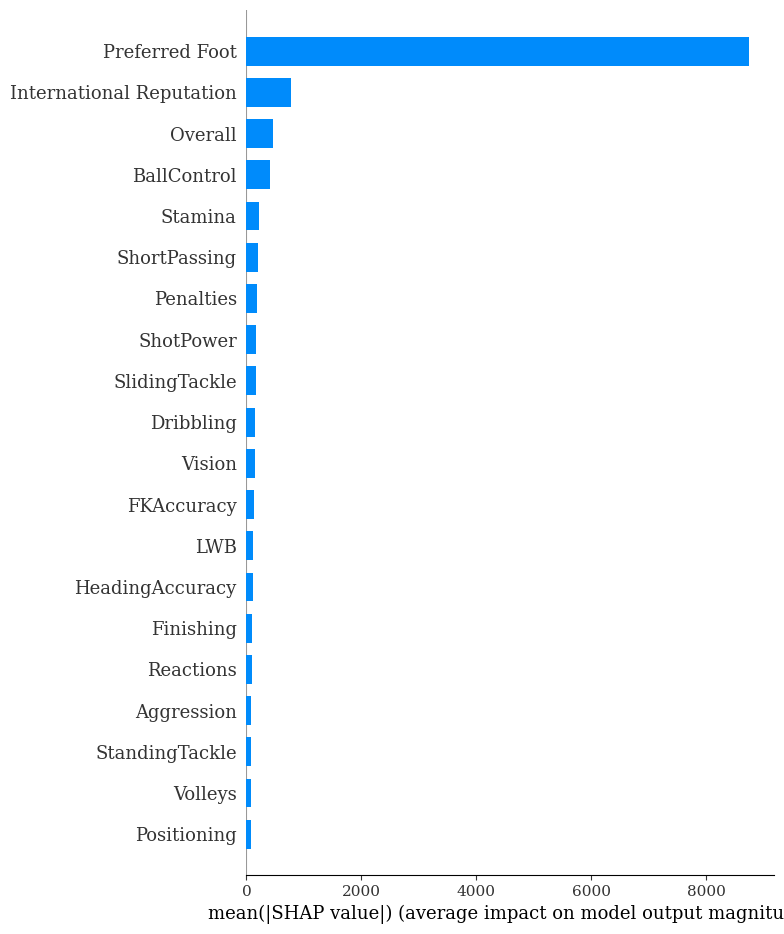

In [ ]:
# Summary plot
shap.summary_plot(test_gb_shap_values, X_test, plot_type="bar")


In [ ]:
# Grafiquemos los valores SHAP para un ejemplo del conjunto de test
### CÓDIGO AQUÍ ###

shap.initjs()

# Individual SHAP value plot for a specific instance (e.g., the first instance in the test set)
instance_index = 0
force_plot_html = shap.force_plot(gb_explainer.expected_value, test_gb_shap_values[instance_index], X_test.iloc[instance_index],show=False)
HTML(force_plot_html.html())

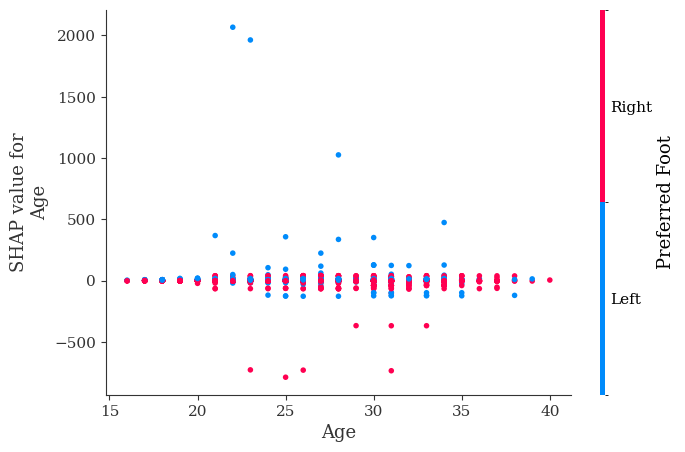

In [ ]:
# Grafiquemos la dependencia de los valores SHAP con la variable "Age"
shap.dependence_plot('Age', test_gb_shap_values, X_test)